In [ ]:
#@markdown ## Set Up (reinicar entorno luego de completado)
%pip install --force-reinstall numpy==1.23.5

In [ ]:
%pip install dowhy --quiet
import dowhy
import numpy as np
import pandas as pd

from graphviz import Digraph, Source
from scipy.stats import bernoulli

# Introducción a la Inferencia Causal

# Ejercicios - Clase 2

Consideremos este ejemplo, extraído y modificado a partir del libro _Causality_ de Pearl.

Supongamos que tenemos un pequeño terreno cultivado con riego automático. La entrada al terreno puede estar mojada debido a la lluvia ($L = 1$) pero también debido a que se encendió el riego automático ($R = 1$).

Este grafo ilustra nuestras hipótesis sobre cómo se relacionan distintas variables: la estación del año actual ($E = 0$ es la temporada seca, $E=1$ la temporada húmeda), el si llovió o no hoy, el estado del sistema de riego, si el suelo está mojado ($M = 1$), y si está resbaladizo ($Y = 1$). Notemos que todas las variables en este caso son binarias (adoptan el valor $0$ o $1$ según un caso u otro).

En este caso, podríamos tomar $L = \text{lluvia}$ como nuestra variable de tratamiento, mientras que $Y = \text{resbaladizo}$ es el "resultado", y así preguntarnos qué efecto causal tiene la lluvia sobre el estado resbaladizo de la entrada al terreno.

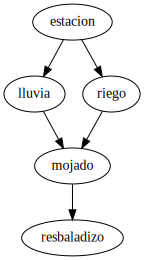

In [ ]:
# No modificar
graph_dot_source = 'digraph {\
  lluvia;\
  estacion;\
  riego;\
  mojado;\
  resbaladizo;\
  estacion -> lluvia;\
  lluvia -> mojado; riego -> mojado;\
  mojado -> resbaladizo;\
  estacion -> riego;\
  }'
dot = Source(graph_dot_source)
dot

# Ejercicio 1

Implementar una red causal bayesiana que tenga a este DAG como grafo subyacente. Para eso, basarse en las siguientes tablas de probabilidad condicional (al igual que en el notebook principal de la clase 2):

\begin{align}
 p(E = 1) &= 0.5 \\
 p(L = 1 \mid E = 0) &= 0.3 \\
 p(L = 1 \mid E = 1) &= 0.65 \\
 p(R = 1 \mid E = 0) &= 0.4 \\
 p(R = 1 \mid E = 1) &= 0.2 \\
 p(M = 1 \mid L = l, R = r) &= \begin{cases}
  1 & \text{ si $l=1$ o $r=1$} \\
  0.1 & \text{ si $l=r=0$}
 \end{cases} \\
p(Y = 1 \mid M = 1) &= 1 \\
p(Y = 1 \mid M = 0) &= 0.1
\end{align}

Las intuiciones son:
* Se generarán tantas observaciones de estación húmeda como de estación seca.
* Hay más lluvia en estación húmeda, mientras que hay más riego en estación seca.
* Si llovió o hay riego, el suelo estará mojado, pero si no, también tiene una probabilidad baja de estar mojado por otras razones.
* Si el suelo está mojado, definitivamente estará resbaladizo, pero si no, también tiene una probabilidad baja de estar resbaladizo por otras razones.


El resultado debe ser una función `samplear_modelo(n)` que, dado $n$, devuelva un DataFrame de `pandas` con $n$ filas, donde cada fila es una muestra aleatoria $(e, l, r, m, y)$ de la distribución de probabilidad conjunta $p(E, L, R, M, Y)$. Los nombres de las columnas deben ser `['estacion', 'lluvia', 'riego', 'mojado', 'resbaladizo']`.

_Ayuda_: dado que todas las variables son binarias, las tablas de probabilidad se pueden implementar como distribuciones de Bernoulli en las que el parámetro $p$ (probabilidad de obtener $1$) sea una función de los valores de las variables padre. Por ejemplo, para la variable $E$, podemos definir

In [ ]:
def samplear_E(n):
  return bernoulli.rvs(0.5, size=n)
def computar_L(es): # es : array de valores de e
  return np.array([bernoulli.rvs(0.3 if e == 0 else 0.65) for e in es])

# Ejercicio 2

Ahora que tenemos el modelo generativo, _olvidémonos_ de que lo conocemos e imaginemos que tenemos un dataset en el que todas las variables son observables.

**(a)** Bajo las hipótesis causales codificadas en el grafo de arriba, ¿Qué método o métodos de identificación puedo aplicar? ¿Cuál sería mi conjunto de ajuste y por qué?

**(b)** Verificar nuestras respuestas con DoWhy. Para ello, generar $10000$ observaciones usando la función `samplear_modelo(n)`.

Paso b.i: Usando `dowhy`, inicializar un objeto `CausalModel` usando como DAG de hipótesis causales el DAG que presentamos más arriba.

Paso b.ii: Pedir a `dowhy` que identifique el ATE y en caso de lograrlo, estimarlo a través del método de regresión lineal. Interpretar los resultados tanto del paso de identificación como del paso de estimación.

> _Ayudas_:
> 1. Usen el _string_ de descripción del grafo con el cual lo visualizamos más arriba, guardado en la variable `graph_dot_source`, y pasarle ese string al constructor de la clase `CausalModel`.
> 2. Para nombrar a las variables, usen siempre los nombres de las columnas del dataframe, que a su vez deben coincidir con los nombres de los nodos en el grafo (tal como aparecen en el string `graph_dot_source` que define el grafo).
> 3. Cuando inicializamos el objeto `CausalModel` debemos pasarle el argumento opcional `proceed_when_unidentifiable=True` para asegurarnos de que no asuma la existencia de confusores no observados y nos permita identificar usando nuestro modelo (es decir, de esta forma se asume que nuestro modelo no omite confusores).

<mark>Atención</mark>: en el resultado que devuelva DoWhy, ignorar lo que diga sobre el método frontdoor. Actualmente hay un bug en DoWhy para ese método.

# Ejercicio 3

Ahora en cambio tenemos un dataset que omite las variables $E$ y $R$. Intuitivamente podemos pensar que el dataset consiste en observaciones que hizo alguien al pasar en auto cerca de la entrada al terreno, sin anotar la fecha ni fijarse en si el riego estaba o había sido activado hace poco. ¿Podemos aún así identificar el efecto causal con alguna de las herramientas vistas en la clase? ¿Por qué?


# Ejercicio 4

A partir de las hipótesis causales codificadas en el DAG y de los datos en el dataset (a), nos hacemos la preguntas:

1. ¿Cuál es la probabilidad de que el piso esté mojado si el riego no estaba encendido?
2. ¿Cuál es la probabilidad de que estemos en estación húmeda si el riego no estaba encendido?


3. Si hipotéticamente consideramos una situación en la que el sistema de riego fue retirado del terreno, _sin cambiar nada más_, ¿Cuál sería la probabilidad de que el piso esté mojado?
4. Todavía en esta situación hipotética, ¿Cuál sería la probabilidad de que estemos en estación húmeda?

Para cada pregunta, identificar cuál es la expresión matemática por la que nos estamos preguntando, y responder a la pregunta de manera numérica. Interpretar la relación entre las respuestas a 1 y 3 por un lado, y a 2 y 4 por el otro.

_Ayuda 1_: usar el dataset (a), o generar uno similar, para calcular frecuencias de ocurrencia de distintos eventos. Recordar que el dataset (a) había sido creado con un tamaño total de 10000 muestras.

_Ayuda 2_: si se necesita calcular cantidades intervencionales, escribir una nueva función `samplear_modelo_modificado(n)`, modificando la función `samplear_modelo(n)` que escribieron antes, respetando la regla de factorización truncada. Esto será muchísimo más fácil que usar `dowhy.gcm`, dado que se trata de variables aleatorias binarias y no es necesario ajustar ningún modelo a los datos.
